# Valuación de opciones con aprendizaje estadístico

### 1. Librerías

In [1]:
# ==============================================================================
# Preparación datos
# ==============================================================================
import pandas as pd
import numpy as np
import yfinance as yf
import time
# ==============================================================================
# Preprocesado y modelado
# ==============================================================================
from sklearn.svm import SVC
from sklearn.svm import SVR
from scipy import stats
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

### 2. Funciones

In [18]:
#----------------------             FUNCIONES              -------------------------------
def tasa_libre_riesgo(start_date, end_date):
    """
    Obtiene la tasa libre de riesgo utilizando el rendimiento del bono del Tesoro de Estados Unidos a 10 años.

    start_date: str, Fecha de inicio del rango para obtener los datos del bono (en formato 'YYYY-MM-DD')
    end_date: str, Fecha de finalización del rango para obtener los datos del bono (en formato 'YYYY-MM-DD')

    Retorna:
    float, Tasa libre de riesgo anualizada calculada a partir del rendimiento del bono del Tesoro a 10 años 
    en el último día del rango de fechas especificado. El valor es un número decimal representando el rendimiento 
    (por ejemplo, un 3.5% se retorna como 0.035).
    """
    
    # Símbolo del bono del Tesoro a 10 años en Estados Unidos
    symbol = "^TNX"
    
    # Crear un objeto Ticker con el símbolo especificado
    tnx = yf.Ticker(symbol)
    
    # Obtener el historial de precios de cierre ajustados dentro del rango de fechas
    historial_precios = tnx.history(start=start_date, end=end_date)
    
    # Último precio de cierre ajustado (rendimiento)
    rateRiskFree = historial_precios['Close'].iloc[-1]/100
    return rateRiskFree

def tasa_ret_anual_precio_act(lista, start_date, end_date):
    """
    Calcula el precio actual y la tasa de retorno anualizada de una lista de activos financieros.
    
    lista: list o str, Lista de símbolos de activos (acciones, ETFs, etc.) o un único símbolo en formato string.
           Si se proporciona un solo símbolo, este será convertido en una lista.
    start_date: str, Fecha de inicio del rango para obtener los datos históricos (en formato 'YYYY-MM-DD').
    end_date: str, Fecha de finalización del rango para obtener los datos históricos (en formato 'YYYY-MM-DD').
    
    Retorna:
    pd.DataFrame, DataFrame con los siguientes campos:
        - 'symbol': El símbolo del activo.
        - 'S0': El precio actual (último precio ajustado) del activo.
        - 'mu': La tasa de retorno anualizada (drift) calculada a partir de los retornos logarítmicos diarios de los precios.
    
    La tasa de retorno anualizada (drift) se calcula utilizando los retornos logarítmicos diarios de los precios ajustados
    para cada activo en el rango de fechas especificado, asumiendo un año de aproximadamente 252 días hábiles de mercado.
    """
    if not isinstance(lista, list):
        lista = [lista]  # Convertirlo en una lista
    
    # Crear un DataFrame vacío para almacenar los resultados
    df = pd.DataFrame(columns=['symbol', 'S0', 'mu'])
    
    for i in lista:
        # Crear el objeto Ticker con el símbolo correspondiente
        ticker = yf.Ticker(i)
        
        # Obtener el precio actual (último precio ajustado)
        price = ticker.history(period='1d')['Close'].iloc[0]
        
        # Obtener el historial de precios en el rango de fechas especificado
        data = ticker.history(start=start_date, end=end_date)
        data = data.reset_index()
        
        # Crear un DataFrame con las fechas y los precios ajustados
        retorn = pd.DataFrame({'Date': data['Date'], 'Price': data['Close']})
        
        # Calcular los retornos logarítmicos
        retorn['Log_Returns'] = np.log(retorn['Price'] / retorn['Price'].shift(1))
        
        # Calcular la deriva anualizada (drift)
        drift = retorn['Log_Returns'].mean() * 252  # Aproximadamente 252 días de mercado por año
        
        # Agregar los resultados al DataFrame
        temp = [i, price, drift]
        df.loc[len(df)] = temp

    return df


     
def obtener_opciones(portfolio, start_date, end_date):
    """
    Obtiene las opciones de compra (calls) y de venta (puts) para un conjunto de activos, 
    filtra las opciones 'in-the-money' dentro de un rango de fechas y con volatilidad implícita baja.

    portfolio: list o str, Lista de símbolos de activos (acciones, ETFs, etc.) o un único símbolo en formato string.
               Si se proporciona un solo símbolo, este será convertido en una lista.
    start_date: str, Fecha de inicio del rango para obtener los datos de las opciones (en formato 'YYYY-MM-DD').
    end_date: str, Fecha de finalización del rango para obtener los datos de las opciones (en formato 'YYYY-MM-DD').

    Retorna:
    pd.DataFrame, DataFrame con las opciones 'calls' y 'puts' para los activos en el portfolio,
    filtradas por las siguientes condiciones:
        - Las opciones deben ser 'in-the-money' (ITM).
        - La volatilidad implícita debe ser menor a 3.
        - El rango de fechas debe estar entre `start_date` y `end_date`.
        
    El DataFrame contiene las siguientes columnas:
        - 'contractSymbol': El símbolo del contrato de la opción.
        - 'lastTradeDate': La fecha del último intercambio de la opción.
        - 'strike': El precio de ejercicio de la opción.
        - 'lastPrice': El último precio de la opción.
        - 'impliedVolatility': La volatilidad implícita de la opción.
        - 'optionType': Tipo de opción ('calls' o 'puts').
        - 'symbol': Símbolo del activo subyacente.
        - 'shortDate': Fecha corta en formato 'YYYY-MM-DD'.
        - 'inTheMoney': Indica si la opción está 'in-the-money'.
    """
    
    if not isinstance(portfolio, list):
        portfolio = [portfolio]  # Convertirlo en una lista
    
    # Crear una lista para almacenar los DataFrames de las opciones
    df_list = []
    
    for symbol in portfolio:
        ticker = yf.Ticker(symbol)
        options = ticker.option_chain()  # Obtiene las opciones (calls y puts)
        df_calls = options.calls
        df_calls['optionType'] = 'calls'
        
        df_puts = options.puts
        df_puts['optionType'] = 'puts'
        
        # Unificamos los 'calls' y 'puts' en un único DataFrame
        df = pd.concat([df_calls, df_puts], ignore_index=True)
        
        # Filtrar por las fechas de negociación
        df['lastTradeDate'] = pd.to_datetime(df['lastTradeDate'])
        df = df[(df['lastTradeDate'] >= start_date) & (df['lastTradeDate'] <= end_date)]
        
        # Filtramos las opciones 'inTheMoney'
        df['inTheMoney'] = df.apply(
            lambda row: (row['optionType'] == 'calls' and row['lastPrice'] > row['strike']) or
                        (row['optionType'] == 'puts' and row['lastPrice'] < row['strike']),
            axis=1
        )
        
        df=df[(df['inTheMoney'] == True) & (df['impliedVolatility'] < 3)]
        
        # Añadir la columna del símbolo
        df['symbol'] = symbol
        
        # Crear una columna con la fecha corta
        df['shortDate'] = df['lastTradeDate'].dt.strftime('%Y-%m-%d')
        
        # Añadir el DataFrame a la lista
        df_list.append(df)
    
    # Concatenamos todos los DataFrames obtenidos
    final_df = pd.concat(df_list, ignore_index=True)
    final_df = final_df.reset_index(drop=True)
    return final_df
 


def condicional( symbol,option_type, strike):
    """
   Calcula el valor de una opción 'in-the-money' (ITM) en función de su tipo (call o put) y precio de ejercicio.

   symbol: str, Símbolo del activo subyacente (por ejemplo, 'AAPL', 'GOOG').
   option_type: str, Tipo de opción ('calls' o 'puts').
   strike: float, Precio de ejercicio de la opción.

   Retorna:
   float, El valor de la opción 'in-the-money' (ITM) si está en el dinero, o 0 si está fuera del dinero (OTM).
         Para una opción de compra ('calls'), el valor es `max(S0 - strike, 0)`.
         Para una opción de venta ('puts'), el valor es `max(strike - S0, 0)`, donde `S0` es el precio actual
         del activo subyacente.

   La función obtiene el precio actual del activo subyacente (`S0`) desde un DataFrame `inf_portfolio`, 
   asumiendo que contiene la columna 'symbol' con los símbolos de los activos y 'S0' con los precios actuales.
   """
    x=inf_portfolio.loc[inf_portfolio['symbol']==symbol].iloc[0]['S0']
    if option_type == "calls":
        return max(x - strike,0)
    else:
        return max(-(x - strike),0) 
    

def is_itm(row):
    """
    Determina si una opción está 'in-the-money' (ITM) o 'out-of-the-money' (OTM).

    row: pd.Series, Una fila de un DataFrame que contiene información sobre una opción.
         La fila debe tener al menos las siguientes columnas:
         - 'optionType': Tipo de opción, que puede ser 'calls' o 'puts'.
         - 'lastPrice': El último precio de la opción.
         - 'strike': El precio de ejercicio de la opción.

    Retorna:
    str, 'ITM' si la opción está 'in-the-money' o 'OTM' si la opción está 'out-of-the-money'.
         - Para opciones de compra ('calls'), la opción está 'ITM' si el precio de la opción es mayor que el precio de ejercicio.
         - Para opciones de venta ('puts'), la opción está 'ITM' si el precio de la opción es menor que el precio de ejercicio.
    """
    if row['optionType']== 'calls':
        return 'ITM' if row['lastPrice']>row['strike'] else 'OTM'
    elif row['optionType']== 'puts':
        return 'ITM' if row['lastPrice']<row['strike'] else 'OTM'
    

#-----------------------------------------------------------------------------------------
def simulate_gbm(mu, sigma, s0, T, dt, num_paths):
    """
    Simula trayectorias de precios de un activo siguiendo un proceso de Geometric Brownian Motion (GBM).

    mu: float, Tasa de retorno esperada del activo (drift), en formato decimal.
    sigma: float, Volatilidad del activo (desviación estándar anual), en formato decimal.
    s0: float, Precio inicial del activo (precio del activo en el momento 0).
    T: float, Tiempo total de la simulación, en años.
    dt: float, Paso temporal para la simulación, en años.
    num_paths: int, Número de trayectorias a simular.

    Retorna:
    np.ndarray, Una matriz de tamaño (num_paths, num_steps) que contiene las trayectorias simuladas del precio del activo.
    Cada fila representa una trayectoria de precio del activo y cada columna representa un paso de tiempo.

    El proceso de simulación utiliza la fórmula del GBM:
        S(t) = S(0) * exp[(mu - 0.5 * sigma^2) * t + sigma * W(t)],
    donde:
        - S(t) es el precio del activo en el tiempo t.
        - S(0) es el precio inicial.
        - mu es la tasa de retorno esperada del activo (drift).
        - sigma es la volatilidad.
        - W(t) es un proceso de Wiener (caminata aleatoria).
        - t es el tiempo transcurrido (desde 0 hasta T).
    """
   
    np.random.seed(99)
    num_steps = int(T / dt) + 1
 
    times = np.linspace(0, T, num_steps)  # Crea los tiempos de la simulación
    paths = np.zeros((num_paths, num_steps))  # Inicializa la matriz de trayectorias

    for i in range(num_paths):
        # Generar incrementos normales aleatorios
        dW = np.random.normal(0, np.sqrt(dt), num_steps - 1)
        # Calcular la suma acumulada de los incrementos
        cumulative_dW = np.cumsum(dW)
        # Calcular la trayectoria del precio utilizando la fórmula de GBM
        paths[i, 1:] = s0 * np.exp((mu - 0.5 * sigma**2) * times[1:] + sigma * cumulative_dW)

    return paths


def longstaff_schwartz(paths, strike, r,option_type):
    """
    Valora una opción americana utilizando el método de Longstaff-Schwartz basado en regresión.

    paths: np.ndarray, Matriz de trayectorias simuladas del precio del activo subyacente. 
           Cada fila representa una trayectoria y cada columna un paso de tiempo.
           La última columna representa el valor en el tiempo T.

    strike: float, El precio de ejercicio (strike price) de la opción.

    r: float, La tasa de interés libre de riesgo anual (en formato decimal).

    option_type: str, Tipo de opción. Puede ser "calls" (opción de compra) o "puts" (opción de venta).

    Retorna:
    tuple:
        - option_price: float, El valor estimado de la opción basado en el método de Longstaff-Schwartz.
        - lower_interval: float, Límite inferior del intervalo de confianza del 95%.
        - upper_interval: float, Límite superior del intervalo de confianza del 95%.
        - option_valuation: pd.DataFrame, Contiene las decisiones de ejercicio para cada trayectoria (Moda del tiempo dt donde se ejerce la opcion).
        - vector_valuation: pd.DataFrame, Un DataFrame con las decisiones de ejercicio de la opción a lo largo de todas las trayectorias.
    
    Descripción:
    La función implementa el método de valuación de opciones americanas propuesto por Longstaff y Schwartz,
    el cual utiliza una regresión para estimar el valor de ejercicio en cada paso de tiempo y decide si es más
    rentable ejercer la opción o continuar con la estrategia de "hold".

    Procedimiento:
    1. Inicializa los flujos de caja en función del tipo de opción (call o put).
    2. Realiza la regresión en cada paso de tiempo para estimar el valor de ejercicio condicional.
    3. Aplica las reglas de ejercicio temprano:
        - Si la continuación es mayor que el flujo de caja, el ejercicio se pospone.
        - Si el ejercicio es más beneficioso que la continuación, se ejerce la opción.
    4. Calcula el precio presente de la opción descontando los flujos de caja.
    5. Calcula el intervalo de confianza del 95% utilizando el error estándar y la desviación estándar.
    """
   
    # Inicialización de los flujos de caja
    cash_flows = np.zeros_like(paths)

    # Determinamos los flujos de caja según el tipo de opción (calls o puts)
    if option_type == "calls":
        for i in range(0, cash_flows.shape[0]):
            cash_flows[i] = [max(x - strike, 0) for x in paths[i]]
    else:
        for i in range(0, cash_flows.shape[0]):
            cash_flows[i] = [max(-(x - strike), 0) for x in paths[i]]

    # Configuración de los pasos de tiempo
    T = cash_flows.shape[1] - 1
    r_t = r / T  # Tasa de descuento por paso de tiempo

    # Implementación de la regresión en cada paso de tiempo
    for t in range(T, 0, -1):
        # Determinar si la opción está 'in-the-money' en el tiempo t-1
        if option_type == "calls":
            in_the_money = paths[:, t-1] > strike
        else:
            in_the_money = paths[:, t-1] < strike

        # Si hay trayectorias 'in-the-money', aplicar la regresión
        if len(paths[in_the_money, t-1]) > 0:
            # Datos para la regresión: precios en t-1 y flujos de caja en t
            X = (paths[in_the_money, t-1]).reshape(-1, 1)
            Y = cash_flows[in_the_money, t] * np.exp(-r_t)
            model_sklearn = SVR(kernel="rbf", C=1e1, gamma=0.1)
            model = model_sklearn.fit(X, Y)
            conditional_exp = model.predict(X)

            # Continuación de la opción (regresión)
            continuations = np.zeros_like(paths[:, t])
            continuations[in_the_money] = conditional_exp
        else:
            continuations = np.zeros_like(paths[:, t])

        # Regla de decisión: si la continuación es mayor que el flujo de caja, no ejercer
        cash_flows[:, t] = np.where(continuations > cash_flows[:, t], 0, cash_flows[:, t])

        # Segunda regla: si se ejerce la opción antes, los flujos de caja futuros son 0
        exercised_early = continuations < cash_flows[:, t]
        cash_flows[:, 0:t][exercised_early, :] = 0

    # Convertir los flujos de caja en un DataFrame para mejor visualización
    decision = pd.DataFrame(cash_flows)
    option_valuation = decision.idxmax(axis=1)
    option_valuation = option_valuation.tolist()
    option_valuation = pd.DataFrame(option_valuation)
    
    vector_valuation = option_valuation

    # Filtrar las decisiones de ejercicio (no se ejerce en t=0)
    option_valuation = option_valuation[option_valuation[0] != 0]
    
    # Calcular la moda de las decisiones de ejercicio diferentes de 0 (valor de ejercicio)
    option_valuation = option_valuation.mode()[0][0] if not option_valuation.empty else 0
    
    # Calcular los flujos de caja finales
    final_cfs = np.zeros((cash_flows.shape[0], 1), dtype=float)
    for i, row in enumerate(final_cfs):
        final_cfs[i] = max(cash_flows[i, :])

    # Convertir a DataFrame para el análisis final
    final_cfs = pd.DataFrame(final_cfs)
    final_cfs = pd.concat([final_cfs, vector_valuation], axis=1)
    final_cfs.columns = ['price', 'exercise']

    # Calcular el valor presente de los flujos de caja
    final_cfs['present_value'] = final_cfs['price'] / np.exp(r_t * final_cfs['exercise'])

    # Precio de la opción como el valor promedio de los valores presentes
    option_price = np.mean(final_cfs['present_value'])

    # Transponer el vector de valoración para el retorno
    vector_valuation = vector_valuation.T

    # Cálculos del intervalo de confianza del 95%
    # Media
    average = np.mean(final_cfs['present_value'])
    
    # Desviación estándar
    standard_deviation = np.std(final_cfs['present_value'], ddof=1)

    # Tamaño de la muestra
    n = paths.shape[0]

    # Error estándar
    standard_error = standard_deviation / np.sqrt(n)
    
    # Valor crítico Z para el intervalo de confianza del 95%
    confidence_level = 0.95
    z = stats.norm.ppf(1 - (1 - confidence_level) / 2)
    
    # Intervalo de confianza
    margin_error = z * standard_error
    lower_interval = average - margin_error
    upper_interval = average + margin_error

    return option_price, lower_interval, upper_interval, option_valuation, vector_valuation



# Función para calcular el valor de una opción call o put usando Black-Scholes
def black_scholes(option_type, S0, K, T, r, sigma):
    """
    Calcula el valor de una opción europea usando el modelo de Black-Scholes.

    option_type: str, "call" o "put" (tipo de opción)
    S0: float, precio actual del activo subyacente
    K: float, precio de ejercicio (strike price)
    T: float, tiempo hasta el vencimiento en años
    r: float, tasa de interés libre de riesgo anual (en formato decimal)
    sigma: float, volatilidad anual del activo subyacente (en formato decimal)
    """
    # Calcular d1 y d2
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calcular el valor de la opción
    if option_type.lower() == 'calls':
        option_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == 'puts':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("El tipo de opción debe ser 'calls' o 'puts'")
    
    return option_price

    
def american_option_monte_carlo( paths, mu, sigma, s0, K, T, r, option_type='calls'):
    """
    Calcula el valor de una opción americana utilizando simulaciones de Monte Carlo y ejercicio anticipado.
    mu: float, La tasa de retorno esperada del activo subyacente (en formato decimal).
    sigma: float, La volatilidad anual del activo subyacente (en formato decimal).
    s0: float, El precio inicial del activo subyacente.
    K: float, El precio de ejercicio (strike price) de la opción.
    T: float, El tiempo hasta el vencimiento de la opción (en años).
    r: float, La tasa de interés libre de riesgo anual (en formato decimal).
    option_type: str, Opcional. El tipo de opción, puede ser 'calls' (opción de compra) o 'puts' (opción de venta). 
                Por defecto es 'calls'.
    paths: np.ndarray, Matriz de trayectorias simuladas del precio del activo subyacente.
           Cada fila representa una trayectoria simulada, y cada columna representa un paso de tiempo.

    Retorna:
    float: El valor estimado de la opción americana con ejercicio anticipado basado en la simulación de Monte Carlo.
    Nota:
    
    Esta función no implementa explícitamente la lógica de ejercicio anticipado en cada paso de tiempo. Si se desea implementar el ejercicio anticipado, será necesario usar un enfoque más complejo (como el de Longstaff-Schwartz) o un modelo de árbol binomial.
    """
    # Descontar los pagos de la opción y considerar el ejercicio anticipado
    payoffs = np.zeros(paths.shape[0])
    for i in range(paths.shape[0]):
        # Al final del vencimiento
        if option_type == 'calls':
            payoffs[i] = max(0, paths[i, -1] - K)  # Opción call
        elif option_type == 'puts':
            payoffs[i] = max(0, K - paths[i, -1])  # Opción put

    # Descuento al valor presente de los pagos
    payoff_mean = np.mean(payoffs)
    option_price = np.exp(-r * T) * payoff_mean
    return option_price



# Función para calcular el valor de una opción americana con el modelo de árbol binomial
def binomial_tree_american_option(S0, K, T, r, sigma, n, option_type='calls'):
    """
    Valuación de una opción americana utilizando el modelo de árbol binomial.

    S0: Precio inicial del activo subyacente
    K: Precio de ejercicio (strike)
    T: Tiempo hasta el vencimiento (en años)
    r: Tasa de interés libre de riesgo (en formato decimal)
    sigma: Volatilidad del activo subyacente (en formato decimal)
    n: Número de pasos del árbol binomial
    option_type: Tipo de opción ('calls' o 'puts')
    """
    # Paso de tiempo
    dt = T / n

    # Cálculo de los factores de subida (u) y bajada (d)
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))

    # Cálculo de la probabilidad de subida (p)
    p = (np.exp(r * dt) - d) / (u - d)

    # Inicializar el árbol de precios
    prices = np.zeros((n + 1, n + 1))

    # Llenar el árbol de precios
    for i in range(n + 1):
        prices[i, 0] = S0 * (u ** i) * (d ** (n - i))

    # Inicializar el valor de la opción al vencimiento
    option_values = np.zeros((n + 1, n + 1))

    # Calcular el valor de la opción en las hojas (en el vencimiento)
    for i in range(n + 1):
        if option_type == 'calls':
            option_values[i, n] = max(0, prices[i, n] - K)
        elif option_type == 'puts':
            option_values[i, n] = max(0, K - prices[i, n])

    # Retroceder en el árbol para calcular el valor de la opción en el tiempo presente
    for j in range(n - 1, -1, -1):
        for i in range(j + 1):
            # Valor si no se ejerce la opción
            hold_value = np.exp(-r * dt) * (p * option_values[i, j + 1] + (1 - p) * option_values[i + 1, j + 1])
            # Valor si se ejerce la opción
            exercise_value = 0
            if option_type == 'calls':
                exercise_value = max(0, prices[i, j] - K)
            elif option_type == 'puts':
                exercise_value = max(0, K - prices[i, j])
            
            # El valor de la opción americana es el máximo entre ejercer o esperar
            option_values[i, j] = max(exercise_value, hold_value)

    # El valor de la opción en el tiempo 0 es el valor en el primer nodo (nodo raíz)
    return option_values[0, 0]
    

def longstaff_schwartz_polinomios(paths, strike, r, option_type, poly_degree=2):
    """
    Valora una opción americana utilizando el método de Longstaff-Schwartz basado en una regresión lineal.

    paths: np.ndarray, Matriz de trayectorias simuladas del precio del activo subyacente. 
           Cada fila representa una trayectoria y cada columna un paso de tiempo.
           La última columna representa el valor en el tiempo T.

    strike: float, El precio de ejercicio (strike price) de la opción.

    r: float, La tasa de interés libre de riesgo anual (en formato decimal).

    option_type: str, Tipo de opción. Puede ser "calls" (opción de compra) o "puts" (opción de venta).

    poly_degree: int, El grado del polinomio a usar en la regresión (mayor o igual a 1).

    Retorna:
        - option_price: float, El valor estimado de la opción basado en el método de Longstaff-Schwartz.
    """
   
    # Inicialización de los flujos de caja
    cash_flows = np.zeros_like(paths)

    # Determinamos los flujos de caja según el tipo de opción (calls o puts)
    if option_type == "calls":
        for i in range(0, cash_flows.shape[0]):
            cash_flows[i] = [max(x - strike, 0) for x in paths[i]]
    else:
        for i in range(0, cash_flows.shape[0]):
            cash_flows[i] = [max(-(x - strike), 0) for x in paths[i]]

    # Configuración de los pasos de tiempo
    T = cash_flows.shape[1] - 1
    r_t = r / T  # Tasa de descuento por paso de tiempo

    # Implementación de la regresión en cada paso de tiempo
    for t in range(T, 0, -1):
        # Determinar si la opción está 'in-the-money' en el tiempo t-1
        if option_type == "calls":
            in_the_money = paths[:, t-1] > strike
        else:
            in_the_money = paths[:, t-1] < strike

        # Si hay trayectorias 'in-the-money', aplicar la regresión
        if np.any(in_the_money):
            # Datos para la regresión: precios en t-1
            X = paths[in_the_money, t-1]
            
            # Crear términos del polinomio: X, X^2, ..., X^poly_degree
            X_poly = np.column_stack([X**i for i in range(1, poly_degree + 1)])

            # Flujos de caja futuros descontados
            Y = cash_flows[in_the_money, t] * np.exp(-r_t)

            # Regresión usando Regresión Lineal 
            model_sklearn = LinearRegression()
            model = model_sklearn.fit(X_poly, Y)
            conditional_exp = model.predict(X_poly)

            # Continuación de la opción (regresión)
            continuations = np.zeros_like(paths[:, t])
            continuations[in_the_money] = conditional_exp
        else:
            continuations = np.zeros_like(paths[:, t])

        # Regla de decisión: si la continuación es mayor que el flujo de caja, no ejercer
        cash_flows[:, t] = np.where(continuations > cash_flows[:, t], 0, cash_flows[:, t])

        # Segunda regla: si se ejerce la opción antes, los flujos de caja futuros son 0
        exercised_early = continuations < cash_flows[:, t]
        cash_flows[:, 0:t][exercised_early, :] = 0

    # Convertir los flujos de caja en un DataFrame para mejor visualización
    decision = pd.DataFrame(cash_flows)
    option_valuation = decision.idxmax(axis=1)  # Tiempo de ejercicio
    option_valuation = pd.DataFrame(option_valuation)

    # Calcular los flujos de caja finales
    final_cfs = np.zeros((cash_flows.shape[0], 1), dtype=float)
    for i in range(final_cfs.shape[0]):
        final_cfs[i] = max(cash_flows[i, :])

    # Convertir a DataFrame para el análisis final
    final_cfs = pd.DataFrame(final_cfs)
    final_cfs = pd.concat([final_cfs, option_valuation], axis=1)
    final_cfs.columns = ['price', 'exercise']

    # Calcular el valor presente de los flujos de caja
    final_cfs['present_value'] = final_cfs['price'] / np.exp(r_t * final_cfs['exercise'])

    # Precio de la opción como el valor promedio de los valores presentes
    option_price = np.mean(final_cfs['present_value'])

    return option_price


def price_value_op( symbol, optionType, strike, impliedVolatility, lastPrice, T, dt, num_paths, rateRiskFree):
    """
    Calcula el valor de una opción utilizando diversos métodos: Longstaff-Schwartz, Black-Scholes, Monte Carlo y Árbol Binomial.

    symbol: str, símbolo del activo subyacente.
    optionType: str, tipo de opción ('calls' o 'puts').
    strike: float, precio de ejercicio de la opción.
    impliedVolatility: float, volatilidad implícita del activo subyacente.
    lastPrice: float, último precio observado del activo subyacente.
    T: float, tiempo hasta el vencimiento de la opción (en años).
    dt: float, tamaño del paso de tiempo para las simulaciones.
    num_paths: int, número de trayectorias simuladas.
    rateRiskFree: float, tasa de interés libre de riesgo anual.

    Retorna:
    tuple: Tupla con los precios de la opción calculados por varios métodos.
    """
    # Obtener el valor de mu (drift) desde el portafolio (suponiendo que 'inf_portfolio' es un DataFrame global)
    mu = inf_portfolio.loc[inf_portfolio['symbol'] == symbol].iloc[0]['mu']

    # Simulación de trayectorias con el modelo GBM
    paths = simulate_gbm(mu, impliedVolatility, lastPrice, T, dt, num_paths)
    
    # Método Longstaff-Schwartz
    option_price, lower_interval, upper_interval, option_valuation, vector_valuation = longstaff_schwartz(
        paths=paths, strike=strike, r=rateRiskFree, option_type=optionType
    )
    
    # Método Black-Scholes
    black_scholes_price = black_scholes(
        option_type=optionType, S0=lastPrice, K=strike, T=T, r=rateRiskFree, sigma=impliedVolatility
    )
    
    # Método Monte Carlo para opciones americanas
    monte_carlo_price = american_option_monte_carlo(
        mu=mu, sigma=impliedVolatility, s0=lastPrice, K=strike, T=T, r=rateRiskFree, option_type=optionType, paths=paths
    )
    
    # Método del Árbol Binomial
    binomial_price = binomial_tree_american_option(
        S0=lastPrice, K=strike, T=T, r=rateRiskFree, sigma=impliedVolatility, n=int(1/dt), option_type=optionType
    )
    # Método del Longstaff Schwartz con polinomio de grado 2
    LSP2=longstaff_schwartz_polinomios(
         paths=paths, strike=strike, r=rateRiskFree, option_type=optionType, poly_degree=2
     )
    # Método del Longstaff Schwartz con polinomio de grado 3
    LSP3=longstaff_schwartz_polinomios(
         paths=paths, strike=strike, r=rateRiskFree, option_type=optionType, poly_degree=3
     )
    return option_price, lower_interval, upper_interval, option_valuation, black_scholes_price, monte_carlo_price, binomial_price,LSP2,LSP3, vector_valuation


    
def obtain_option_values(row, T, dt, num_paths, rateRiskFree):
    """
    Obtiene los valores de la opción (precio, intervalo de confianza, valoración de la opción) usando
    diversos métodos y devuelve los resultados como un pandas.Series.

    row: pd.Series, fila del DataFrame que contiene la información de la opción.
    T: float, tiempo hasta el vencimiento de la opción (en años).
    dt: float, tamaño del paso de tiempo para las simulaciones.
    num_paths: int, número de trayectorias simuladas.
    rateRiskFree: float, tasa de interés libre de riesgo anual.

    Retorna:
    pd.Series, con los resultados de la opción: precio, intervalo de confianza, y otros valores calculados.
    """
    
    # Llamar a la función 'price_value_op' para obtener los precios y valoraciones
    option_price, lower_interval, upper_interval, option_valuation,black_scholes_price, monte_carlo_price, binomial_price,LSP2,LSP3,vector_valuation= price_value_op(
        row['symbol'], row['optionType'], row['strike'], row['impliedVolatility'], row['lastPrice'], T, dt, num_paths, rateRiskFree
    )
 
    # Asegúrate de que vector_valuation se haya devuelto como una Serie o lista y no un DataFrame
    # Si es un DataFrame, toma la primera fila (esto dependerá de cómo lo devuelvas en price_value_op)
    vector_valuation = vector_valuation.iloc[0].tolist() if isinstance(vector_valuation, pd.DataFrame) else vector_valuation

    # Devolver los resultados en un pd.Series
    result = pd.Series([
        option_price, lower_interval, upper_interval, option_valuation, black_scholes_price,
        monte_carlo_price, binomial_price,LSP2,LSP3] + vector_valuation)
    
    return result


def convertir_a_string(valor):
     """
     Entrada: Cualquier tipo de valor (int, float, bool, etc.).
     Salida: El valor convertido a cadena de texto (str).
     """
     return str(valor)



### 3. Variables Globales

In [19]:

# Definición de los parámetros de simulación
T = 1  # Total time period (1 year)
dt = 1/1000  # Time increment (daily simulation, approx 1/1000 of a year)
num_paths = 100  # Number of simulation paths

# Fechas para calcular tasa libre de riesgo
start_date = "2023-01-01"
end_date = "2025-12-01"
rateRiskFree = tasa_libre_riesgo(start_date, end_date)  # Tasa libre de riesgo


### 4. Prueba con una sola acción

In [20]:
portfolio = "AAPL"         #Ejemplo de una acción
# Obtener retornos anuales y precios actuales
inf_portfolio = tasa_ret_anual_precio_act(portfolio, start_date, end_date)

# Obtener información sobre las opciones
df = obtener_opciones(portfolio, start_date, end_date)

# Filtrar opciones PUT 'in-the-money' y con volatilidad implícita < 3
df = df[(df['optionType'] == 'puts') & (df['inTheMoney'] == True) & (df['impliedVolatility'] < 3)]

# Tomar la última opción
df = df.tail(1).reset_index()

# Obtener datos relevantes para la simulación
impliedVolatility = df.loc[0, 'impliedVolatility']
r = rateRiskFree
S0 = df.loc[0, 'lastPrice']
mu = inf_portfolio.loc[inf_portfolio['symbol'] == 'AAPL'].iloc[0]['mu']
strike = df.loc[0, 'strike']
optionType = df.loc[0, 'optionType']

# Simulación de trayectorias con GBM
paths = simulate_gbm(mu, impliedVolatility, S0, T, dt, num_paths)

# Cálculo de flujos de caja
cash_flows = np.zeros_like(paths)
for i in range(cash_flows.shape[0]):
    cash_flows[i] = [max(round(x - strike, 2), 0) if optionType == 'calls' else max(-round(x - strike, 2), 0) for x in paths[i]]

# Descuento de los flujos de caja
T_num = cash_flows.shape[1] - 1
r_t = r / T_num  # tasa de descuento por paso de tiempo
for t in range(T_num, 0, -1):
    in_the_money = paths[:, t-1] > strike if optionType == "calls" else paths[:, t-1] < strike
    if len(paths[in_the_money, t-1]) > 0:
        X = paths[in_the_money, t-1].reshape(-1, 1)
        Y = cash_flows[in_the_money, t] * np.exp(-r_t)
        model_sklearn = SVR(kernel="rbf", C=1e1, gamma=0.1)
        model = model_sklearn.fit(X, Y)
        conditional_exp = model.predict(X)
        continuations = np.zeros_like(paths[:, t])
        continuations[in_the_money] = conditional_exp
    else:
        continuations = np.zeros_like(paths[:, t])
    
    cash_flows[:, t] = np.where(continuations > cash_flows[:, t], 0, cash_flows[:, t])
    exercised_early = continuations < cash_flows[:, t]
    cash_flows[:, 0:t][exercised_early, :] = 0

# Calcular el precio de la opción y otros valores
final_cfs = np.max(cash_flows, axis=1)
final_cfs = pd.DataFrame(final_cfs)
final_cfs['present_value'] = final_cfs[0] / np.exp(r_t * final_cfs.index)
option_price = np.mean(final_cfs['present_value'])

# Actualizar el DataFrame original con las valoraciones
df['symbol'] = df['symbol'].map(convertir_a_string)
df['cashFlows'] = df.apply(lambda row: condicional(row['symbol'], row['optionType'], row['strike']), axis=1)
new_cols = df.apply(obtain_option_values, axis=1, T=T, dt=dt, num_paths=num_paths, rateRiskFree=rateRiskFree, result_type="expand")
new_cols.columns = ['optionPrice', 'lowerInterval', 'upperInterval', 'optionValuation', 'black_scholes_price', 'monte_carlo_price', 'binomial_price','lsp2_price','lsp3_price'] + [f'vector_valuation_{i}' for i in range(num_paths)]
df = pd.concat([df, new_cols], axis=1)

valores_distintos = df['optionValuation'].unique()

# Resultados finales
print(df.head())
print(f"Valores únicos de optionValuation: {valores_distintos}")

   index       contractSymbol             lastTradeDate  strike  lastPrice  \
0     63  AAPL250110P00330000 2024-12-27 17:11:31+00:00   330.0       76.6   

    bid    ask  change  percentChange  volume  ...  vector_valuation_90  \
0  86.1  87.35     0.0            0.0     2.0  ...               1000.0   

   vector_valuation_91  vector_valuation_92 vector_valuation_93  \
0               1000.0                999.0               999.0   

  vector_valuation_94 vector_valuation_95 vector_valuation_96  \
0               999.0               999.0              1000.0   

  vector_valuation_97  vector_valuation_98  vector_valuation_99  
0               999.0               1000.0               1000.0  

[1 rows x 128 columns]
Valores únicos de optionValuation: [1000.]


### 5. Vector de acciones

In [21]:
portfolio = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOG']  #Ejemplo de un portafolio

# Obtener retornos anuales y precios actuales
inf_portfolio = tasa_ret_anual_precio_act(portfolio, start_date, end_date)

# Obtener información sobre las opciones
df = obtener_opciones(portfolio, start_date, end_date)

# Calcular flujos de caja usando la función 'condicional'
df['cashFlows'] = df.apply(lambda row: condicional(row['symbol'], row['optionType'], row['strike']), axis=1)

# Crear un DataFrame temporal con todos los valores de la opción
new_cols = df.apply(obtain_option_values, axis=1, T=T, dt=dt, num_paths=num_paths, rateRiskFree=rateRiskFree, result_type="expand")

# Nombres de las nuevas columnas
new_cols.columns = ['optionPrice', 'lowerInterval', 'upperInterval', 'optionValuation', 'black_scholes_price', 'monte_carlo_price', 'binomial_price','lsp2_price','lsp3_price'] + [f'vector_valuation_{i}' for i in range(num_paths)]

# Concatenar las nuevas columnas con el DataFrame original
df = pd.concat([df, new_cols], axis=1)

# Obtener los valores únicos de la columna 'optionValuation'
valores_distintos = df['optionValuation'].unique()

print(df.head())  # Para ver el DataFrame resultante
print(f"Valores únicos de optionValuation: {valores_distintos}")

        contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  META250110C00300000 2025-01-03 16:39:58+00:00   300.0     300.60  304.25   
1  META250110P00180000 2025-01-03 19:35:07+00:00   180.0       0.01    0.00   
2  META250110P00200000 2024-12-05 15:34:53+00:00   200.0       0.02    0.00   
3  META250110P00220000 2024-12-12 19:09:14+00:00   220.0       0.01    0.00   
4  META250110P00240000 2024-12-27 17:04:36+00:00   240.0       0.02    0.00   

      ask    change  percentChange  volume  openInterest  ...  \
0  306.35 -7.299988      -2.370896     1.0          12.0  ...   
1    0.01 -0.010000     -50.000000     2.0           6.0  ...   
2    0.01  0.000000       0.000000     NaN           2.0  ...   
3    0.01  0.000000       0.000000     NaN           2.0  ...   
4    0.01  0.000000       0.000000     2.0           2.0  ...   

   vector_valuation_90  vector_valuation_91 vector_valuation_92  \
0                 48.0                214.0               926.0   


### 6. Prueba con una acción para graficar

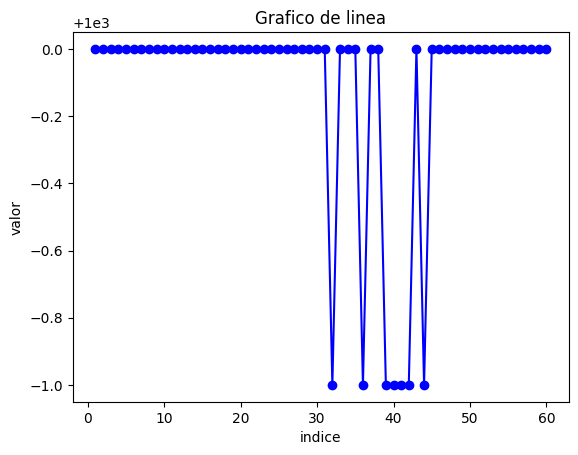

In [22]:
df1=df[df['symbol']=='AMZN'].copy()


import matplotlib.pyplot as plt

x= range (1, len(df1)+1)
plt.plot(x, df1['optionValuation'], marker ='o',color='b', linestyle='-')

plt.title('Grafico de linea')
plt.xlabel('indice')
plt.ylabel('valor')

plt.show()